# 12.4. Simulating a partial differential equation — reaction-diffusion systems and Turing patterns

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation 
from PIL import Image
import os
import math
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
%matplotlib inline

In [2]:
a = 2.8e-4
b = 5e-3
tau = .1
k = -.005

In [3]:
size = 100  # size of the 2D grid
dx = 20 #. / size  # space step

In [16]:
T = 5  # total time
dt = .001  # time step
n = int(T / dt)  # number of iterations

sigma = 400 * np.eye(2)
mu = [50, 50]
scale = 100/0.03978873577297385

def vFunc(x, y):
    global size
    if y == size / 2:
        return [0, 0]
    else:
        return np.array([(-1 * (x-(size/2))) / (y-(size/2)), (-1 * (x-(size/2))) / (y-(size/2))])
    
    
def sinFunc(x, y):
    global size
    sgn = lambda x: x/abs(x) if x != 0 else 0
    return np.array([sgn(x) / 10, sgn(y) / 10])
    

[[[-0.1 -0.1]
  [-0.1 -0.1]
  [-0.1 -0.1]
  ...
  [ 0.1 -0.1]
  [ 0.1 -0.1]
  [ 0.1 -0.1]]

 [[-0.1 -0.1]
  [-0.1 -0.1]
  [-0.1 -0.1]
  ...
  [ 0.1 -0.1]
  [ 0.1 -0.1]
  [ 0.1 -0.1]]

 [[-0.1 -0.1]
  [-0.1 -0.1]
  [-0.1 -0.1]
  ...
  [ 0.1 -0.1]
  [ 0.1 -0.1]
  [ 0.1 -0.1]]

 ...

 [[-0.1  0.1]
  [-0.1  0.1]
  [-0.1  0.1]
  ...
  [ 0.1  0.1]
  [ 0.1  0.1]
  [ 0.1  0.1]]

 [[-0.1  0.1]
  [-0.1  0.1]
  [-0.1  0.1]
  ...
  [ 0.1  0.1]
  [ 0.1  0.1]
  [ 0.1  0.1]]

 [[-0.1  0.1]
  [-0.1  0.1]
  [-0.1  0.1]
  ...
  [ 0.1  0.1]
  [ 0.1  0.1]
  [ 0.1  0.1]]]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(100, 100, 2)
1.0


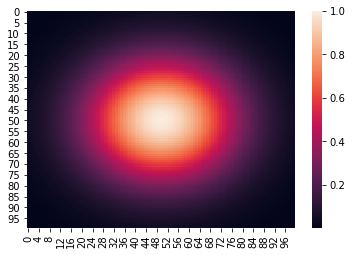

In [17]:

c = np.array([[scale * np.exp(-.5 * (np.array([i,j]) - mu).T @ (np.linalg.inv(sigma) @ (np.array([i,j]) - mu ))) / (np.sqrt((2 * np.pi)**2 * np.linalg.det(sigma))) for j in range(size)] for i in range(size)])
v = np.array(np.array([[sinFunc(x, y) for x in range(int(-1*size/2), int(size/2))] for y in range(int(-1*size/2), int(size/2))]))
print(v)
#v[50, 50] = 0
#v = np.full((100, 100), 1)
#v.shape()
#print(v)
i = np.full((100,100,2),.05)
print(type(i))
print(type(i[0]))
print(type(i[0][0]))
#print(i)
print(i.shape)
d = np.full((100,100),16)
print(np.max(c))
import seaborn as sns
sns.heatmap(c)
#sns.heatmap(v)

In [18]:
def laplacian(Z):
    Ztop = Z[0:-2, 1:-1]
    Zleft = Z[1:-1, 0:-2]
    Zbottom = Z[2:, 1:-1]
    Zright = Z[1:-1, 2:]
    Zcenter = Z[1:-1, 1:-1]
    return (Ztop + Zleft + Zbottom + Zright -
            4 * Zcenter) / dx**2
def grad(Z):
    Ztop = Z[0:-2, 1:-1]
    Zleft = Z[1:-1, 0:-2]
    Zbottom = Z[2:, 1:-1]
    Zright = Z[1:-1, 2:]
    Zcenter = Z[1:-1, 1:-1]
    Zg = np.array([[[(Zright[i][j] - Zleft[i][j])/(2*dx), (Ztop[i][j] - Zbottom[i][j]) / (2*dx)] for j in range(len(Ztop))] for i in range(len(Ztop))])
    Zg = np.pad(Zg, ((1,1),(1,1),(0,0)), 'constant')
    
    return Zg    

def firstTerm(D, c):
    gD = grad(D)
    gc = grad(c)
    ggcx = grad(gc[:, :, 0])
    ggcy = grad(gc[:, :, 1])
    
    Dx = gD[:, :, 0]
    Dy = gD[:, :, 1]
    cx = gc[:, :, 0]
    cy = gc[:, :, 1]
    cxx = ggcx[:, :, 0]
    cyy = ggcy[:, :, 1]
    
    return Dx*cx + D*cxx + Dy*cy + D*cyy

def secondTerm(v, c):
    
    gc = grad(c)
    
    xv = v[:, :, 0]
    yv = v[:, :, 1]
    
    gv = grad(xv)
    
    cx = gc[:, :, 0]
    cy = gc[:, :, 1]
    xvx = grad(xv)[:, :, 0]
    yvy = grad(yv)[:, :, 1]
    
    return cx*xv + c*xvx + cy*yv + c*yvy

In [19]:
def show_patterns(U):
    plt.imshow(U, cmap=plt.cm.copper,
              interpolation='bilinear',
              extent=[-1, 1, -1, 1])
    plt.axis('off')
    #return img 

In [20]:
#fig, axes = plt.subplots(6, 3, figsize=(8, 8))

step_plot = round(n / (24*T)) #n // (2*int(T))

fig = plt.figure()
ims = []
frames = []
# We simulate the PDE with the finite difference
# method.
for i in range(n):
    # We compute the Laplacian of u and v.
    if not i%step_plot:
        print(i)
    #div(D*grad(c)) - div(v*c) + R
    
    deltaC = firstTerm(d,c) + secondTerm(v,c)
    
    c[1:-1,1:-1] = c[1:-1,1:-1] + d[1:-1,1:-1] * deltaC[1:-1,1:-1]
    
    #deltaU = laplacian(U)
    #deltaV = laplacian(V)
    # We take the values of u and v inside the grid.
    #Uc = U[1:-1, 1:-1]
    #Vc = V[1:-1, 1:-1]
    # We update the variables.
    
    #c[1:-1, 1:-1] = -2 * c_row + deltaC * 
    
    
    #U[1:-1, 1:-1], V[1:-1, 1:-1] = \
     #   Uc + dt * (a * deltaU + Uc - Uc**3 - Vc + k),\
      #  Vc + dt * (b * deltaV + Uc - Vc) / tau
    # Neumann conditions: derivatives at the edges
    # are null.
    c[0] = c[1]
    c[-1] = c[-2]
    for Z in (c[1:-1, :]):
        Z[0] = Z[1]
        Z[-1] = Z[-2]


    # We plot the state of the system at
    # 9 different times.
    if i % step_plot == 0:# and i < 9 * step_plot:
        #ax = axes.flat[i // step_plot]
        #fname = 'img' + i
        #img = Image.fromarray(c, 'RGB')
        ims.append(np.copy(c))
        #ims.append(show_patterns(c))
        #ax.set_title(f'$t={i * dt:.2f}$')


0
42
84
126
168
210
252
294
336
378
420
462
504
546
588
630
672
714
756
798
840
882
924
966
1008
1050
1092
1134
1176
1218
1260
1302
1344
1386
1428
1470
1512
1554
1596
1638
1680
1722
1764
1806
1848
1890
1932
1974
2016
2058
2100
2142
2184
2226
2268
2310
2352
2394
2436
2478
2520
2562
2604
2646
2688
2730
2772
2814
2856
2898
2940
2982
3024
3066
3108
3150
3192
3234
3276
3318
3360
3402
3444
3486
3528
3570
3612
3654
3696
3738
3780
3822
3864
3906
3948
3990
4032
4074
4116
4158
4200
4242
4284
4326
4368
4410
4452
4494
4536
4578
4620
4662
4704
4746
4788
4830
4872
4914
4956
4998


<Figure size 432x288 with 0 Axes>

0

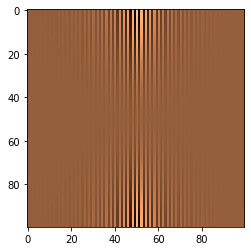

In [21]:
#print(len(ims))
#for c in ims:
#    print(c)


plt.imshow(ims[0], cmap = plt.cm.copper, animated=True)

plt.imshow(ims[1], cmap = plt.cm.copper, animated=True)
plt.imshow(ims[4], cmap = plt.cm.copper, animated=True)
    

#plt.imshow(ims[1], cmap = plt.cm.copper, animated=True)
#plt.imshow(ims[2], cmap = plt.cm.copper, animated=True)


for i in range(len(ims)):
    plt.imshow(ims[i], cmap = plt.cm.copper, animated=True)
    plt.savefig(str(i) + '.png')
    
    frames.append([plt.imshow(ims[i], cmap = plt.cm.copper, animated=True)])
os.system("ffmpeg -r 24 -i %01d.png -vcodec mpeg4 -y movie.mp4")


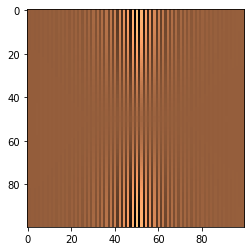

In [22]:
plt.imshow(ims[11], cmap = plt.cm.copper, animated=True)


In [174]:
frames

[[<matplotlib.image.AxesImage at 0x7fe6c3cdec88>],

In [175]:


ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True, repeat_delay=1000)
plt.show()

In [176]:
#fig, ax = plt.subplots(1, 1, figsize=(8, 8))
#show_patterns(c, ax=ax)
FFwriter=animation.FFMpegWriter(fps=24, extra_args=['-vcodec', 'libx264'])
ani.save("movie.mp4", writer=FFwriter)
plt.show()

In [13]:
math.copysign(0,1)

0.0